In [ ]:
#Goals of Project: Train a neural network to solve a handwritten math expression.

In [ ]:
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xainano/handwrittenmathsymbols

 99% 339M/343M [00:03<00:00, 156MB/s]
100% 343M/343M [00:03<00:00, 115MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('handwrittenmathsymbols.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
# Set the path to the handwritten image dataset
handwritten_dataset_path = './dataset/extracted_images'

# Load handwritten images and labels
handwritten_images = []
handwritten_labels = []

for symbol_class in os.listdir(handwritten_dataset_path):
    class_path = os.path.join(handwritten_dataset_path, symbol_class)

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                image = cv2.resize(image, (64, 64))
                handwritten_images.append(image)
                handwritten_labels.append(symbol_class)
            else:
                print(f"Warning: Unable to read or empty image - {image_path}")

        except Exception as e:
            print(f"Error processing image - {image_path}")
            print(f"Error details: {str(e)}")

# Convert lists to NumPy arrays
handwritten_images = np.array(handwritten_images)
handwritten_labels = np.array(handwritten_labels)

# Encode labels
handwritten_label_encoder = LabelEncoder()
handwritten_labels_encoded = handwritten_label_encoder.fit_transform(handwritten_labels) + 10
print("Original Label:", handwritten_labels[0])
print("Encoded Label:", handwritten_labels_encoded[0])
print(len(handwritten_labels_encoded))
print("Unique labels:", np.unique(handwritten_labels))
print("Number of unique labels:", len(np.unique(handwritten_labels_encoded)))


# Remove 0 class label from handwritten dataset
indices_to_remove = np.where(handwritten_labels_encoded == 16)[0]
handwritten_images = np.delete(handwritten_images, indices_to_remove, axis = 0)
handwritten_labels_encoded = np.delete(handwritten_labels_encoded, indices_to_remove)
print("Filtered images shape:", handwritten_images.shape)
print("Filtered labels shape:", handwritten_labels_encoded.shape)
print('New Unique Labels: ', np.unique(handwritten_labels_encoded))


# Normalize pixel values
handwritten_images = handwritten_images / 255.0

# Split the handwritten dataset into training and testing sets
X_handwritten_train, X_handwritten_test, y_handwritten_train, y_handwritten_test = train_test_split(
    handwritten_images, handwritten_labels_encoded, test_size=0.2, random_state=42
)

# Reshape the input data for CNN
X_handwritten_train_resized = X_handwritten_train.reshape(X_handwritten_train.shape[0], 64, 64, 1)
X_handwritten_test_resized = X_handwritten_test.reshape(X_handwritten_test.shape[0], 64, 64, 1)

# Print the shapes of the handwritten datasets
print("X_handwritten_train shape:", X_handwritten_train.shape)
print("X_handwritten_test shape:", X_handwritten_test.shape)
print("y_handwritten_train shape:", y_handwritten_train.shape)
print("y_handwritten_test shape:", y_handwritten_test.shape)

# Load MNIST dataset
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = mnist.load_data()

# Resize MNIST images to match the dimensions of the handwritten image dataset (64 by 64)
X_mnist_train_resized = np.array([cv2.resize(image, (64, 64)) for image in X_mnist_train])
X_mnist_test_resized = np.array([cv2.resize(image, (64, 64)) for image in X_mnist_test])

# Reshape and normalize MNIST data
X_mnist_train_resized = X_mnist_train_resized.reshape(X_mnist_train_resized.shape[0], 64, 64, 1).astype('float32') / 255
X_mnist_test_resized = X_mnist_test_resized.reshape(X_mnist_test_resized.shape[0], 64, 64, 1).astype('float32') / 255

# Print the shapes of the resized MNIST datasets
print("X_mnist_train_resized shape:", X_mnist_train_resized.shape)
print("X_mnist_test_resized shape:", X_mnist_test_resized.shape)
print("y_mnist_train:", y_mnist_train.shape)
print("y_mnist_test:", y_mnist_test.shape)


# Number of images in handwritten datasets
num_images = handwritten_images.shape[0]
print("Number of images in the handwritten dataset:", num_images)

# Concatenate the handwritten image dataset with the MNIST dataset
X_combined_train = np.concatenate([X_handwritten_train_resized, X_mnist_train_resized])
X_combined_test = np.concatenate([X_handwritten_test_resized, X_mnist_test_resized])
y_combined_train = np.concatenate([y_handwritten_train, y_mnist_train])
y_combined_test = np.concatenate([y_handwritten_test, y_mnist_test])

# Ensure consistent sizes for X_combined_test/train, y_combined_test/train
y_combined_train = y_combined_train[:len(X_combined_train)]
y_combined_test = y_combined_test[:len(X_combined_test)]

# One-hot encode the class labels
#y_combined_train = to_categorical(y_combined_train, num_classes=16)
#y_combined_test = to_categorical(y_combined_test, num_classes=16)

# Print the shapes of the combined datasets
print("y_combined_train shape:", y_combined_train.shape)
print("y_combined_test shape:", y_combined_test.shape)

unique_labels_train = np.unique(y_combined_train)
unique_labels_test = np.unique(y_combined_test)

print("Unique labels in training set:", unique_labels_train)
print("Number of unique labels in training set:", len(unique_labels_train))

print("\nUnique labels in test set:", unique_labels_test)
print("Number of unique labels in test set:", len(unique_labels_test))

# Data augmentation for training datasets
#train_datagen = ImageDataGenerator(
    #rotation_range=30,
    #width_shift_range=0.2,
   # height_shift_range=0.2,
   # shear_range=0.2,
   #zoom_range=0.2,
   # horizontal_flip=True,
   # fill_mode='nearest'
#)

# No Data Augmentation
train_datagen = ImageDataGenerator()

# Data augmentation for validation datasets (no augmentation)
val_datagen = ImageDataGenerator()

# Generate augmented training data
train_generator = train_datagen.flow(X_combined_train, y_combined_train, batch_size=64)

# Generate unaltered validation data
val_generator = val_datagen.flow(X_combined_test, y_combined_test, batch_size=64)

# Data augmentation for testing datasets (no augmentation)
test_datagen = ImageDataGenerator()

# Generate unaltered testing data
test_generator = test_datagen.flow(X_combined_test, y_combined_test, batch_size=64)

print(y_combined_train[0])

Original Label: ,
Encoded Label: 14
96429
Unique labels: ['!' '(' ')' '+' ',' '-' '0']
Number of unique labels: 7
Filtered images shape: (90964, 64, 64)
Filtered labels shape: (90964,)
New Unique Labels:  [10 11 12 13 14 15]
X_handwritten_train shape: (72771, 64, 64)
X_handwritten_test shape: (18193, 64, 64)
y_handwritten_train shape: (72771,)
y_handwritten_test shape: (18193,)
11490434/11490434 [==============================] - 0s 0us/step
X_mnist_train_resized shape: (60000, 64, 64, 1)
X_mnist_test_resized shape: (10000, 64, 64, 1)
y_mnist_train: (60000,)
y_mnist_test: (10000,)
Number of images in the handwritten dataset: 90964
y_combined_train shape: (132771,)
y_combined_test shape: (28193,)
Unique labels in training set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Number of unique labels in training set: 16

Unique labels in test set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Number of unique labels in test set: 16
11


In [ ]:
print(y_combined_train[0])
print(y_combined_train[10])
print(recreated_inverse_encoder.inverse_transform(y_combined_train))

15
15


In [ ]:
# Define the CNN model
model = Sequential()

# Convolutional layer with 32 filters, a 3x3 kernel, and 'relu' activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer = regularizers.l1(0.01)))
# Batch Normalization layer
model.add(BatchNormalization())
# Max pooling layer to reduce spatial dimensions
model.add(MaxPooling2D((2, 2)))

# Another convolutional layer with 64 filters and 'relu' activation
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = regularizers.l1(0.01)))
# Batch Normalization layer
model.add(BatchNormalization())
# Another max pooling layer
model.add(MaxPooling2D((2, 2)))

# Another convolutional layer with 128 filters and 'relu' activation
model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer = regularizers.l1(0.01)))
# Batch Normalization layer
model.add(BatchNormalization())
# Another max pooling layer
model.add(MaxPooling2D((2,2)))

# Flatten the output to feed into densely connected layers
model.add(Flatten())

# Dense (fully connected) layer with 128 neurons and 'relu' activation
model.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l1(0.01)))

# Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Output layer with as many neurons as classes and 'softmax' activation for multi-class classification
model.add(Dense(16, activation='softmax', kernel_regularizer = regularizers.l1(0.01)))


def lr_schedule(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * np.exp(0.1 *(10 - epoch))
# Compile the model
lr_callback = LearningRateScheduler(lr_schedule)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    restore_best_weights = True
)


# Train the model on the training data with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_combined_train) // 64,
    epochs=50,
    validation_data= val_generator,
    validation_steps = len(X_combined_test) // 64,
    verbose = 1,
    callbacks=[early_stopping, lr_callback]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                        

NameError: ignored

In [ ]:
print("X_combined_train shape:", X_combined_train.shape)
print("y_combined_train shape:", y_combined_train.shape)
print("X_combined_test shape:", X_combined_test.shape)
print("y_combined_test shape:", y_combined_test.shape)

X_combined_train shape: (132771, 64, 64, 1)
y_combined_train shape: (132771, 16)
X_combined_test shape: (28193, 64, 64, 1)
y_combined_test shape: (28193, 16)


In [ ]:
#Block to save trained model


# Save model architecture to JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the entire model as a single HDF5 file
model.save("full_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load JSON model architecture
json_file_path = '/content/gdrive/MyDrive/Neural Network Model/new_model.json'
with open(json_file_path, 'r') as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)
# Verify the model
model.summary()


Mounted at /content/gdrive
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                           

1/1 [==============================] - 0s 128ms/step
Raw Prediction:  [[4.82966479e-11 8.34102393e-05 9.59948461e-17 1.66026521e-02
  6.26197058e-15 1.55088446e-14 8.97804694e-06 7.70554640e-18
  2.81239698e-09 9.81612027e-01 7.33143893e-11 1.14082954e-14
  1.69290998e-03 8.55651270e-13 5.51555286e-12 1.02384616e-08]]
Actual labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
9


Text(0.5, 1.0, 'Original Image: 9')

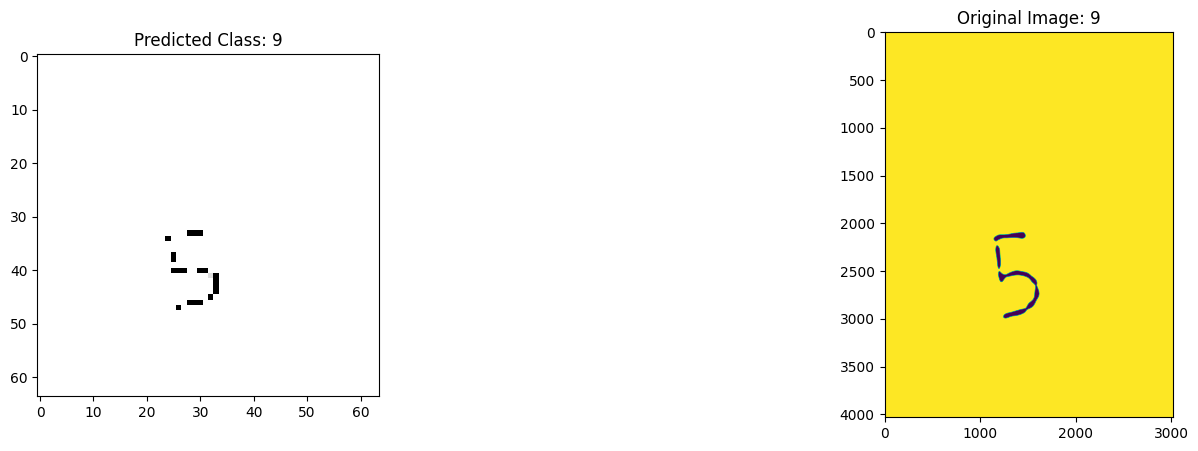

In [ ]:
from tensorflow.keras.models import load_model

# Specify the path to the JSON model file on Google Drive
json_path = '/content/gdrive/MyDrive/Neural Network Model/new_model.json'

# Load the JSON model
with open(json_path, 'r') as json_file:
    model_json = json.load(json_file)

# Load the image in color
image_path = 'IMG_0556c.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Rotate the image by 90 degrees clockwise
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set a threshold value for darker colors
threshold_value = 100

# Create a binary mask for pixels below the threshold
_, mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

resized_mask = cv2.resize(mask, (64, 64))
input_data = np.expand_dims(resized_mask, axis=0)


# Apply the binary mask to the original image
#result_image = cv2.bitwise_and(image, image, mask=mask)
#resized_result_image = cv2.resize(result_image, (64, 64))
#result_data = np.expand_dims(resized_result_image, axis=0)

# Make predictions
predictions = model.predict(input_data)
print('Raw Prediction: ', predictions)

# Convert predictions to class labels
predicted_class_encoded = np.argmax(predictions)

# Recreate the label encoder with the correct set of class labels
recreated_label_encoder = LabelEncoder()
recreated_label_encoder.fit(y_combined_train)
print('Actual labels: ', recreated_label_encoder.classes_)
# Use the label encoder to get the original class label
predicted_class_original = recreated_label_encoder.inverse_transform([predicted_class_encoded])[0]
print(predicted_class_original)

# Plot the original image with the predicted outcome
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(resized_mask, cmap='gray')
plt.title(f'Predicted Class: {predicted_class_original}')

#plt.subplot(1, 3, 2)
#plt.imshow(resized_result_image)
#plt.title(f'Predicted Class: {predicted_class_original}')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title(f'Original Image: {predicted_class_original}')


Text(0.5, 1.0, 'Result Image (Darker Colors Only)')

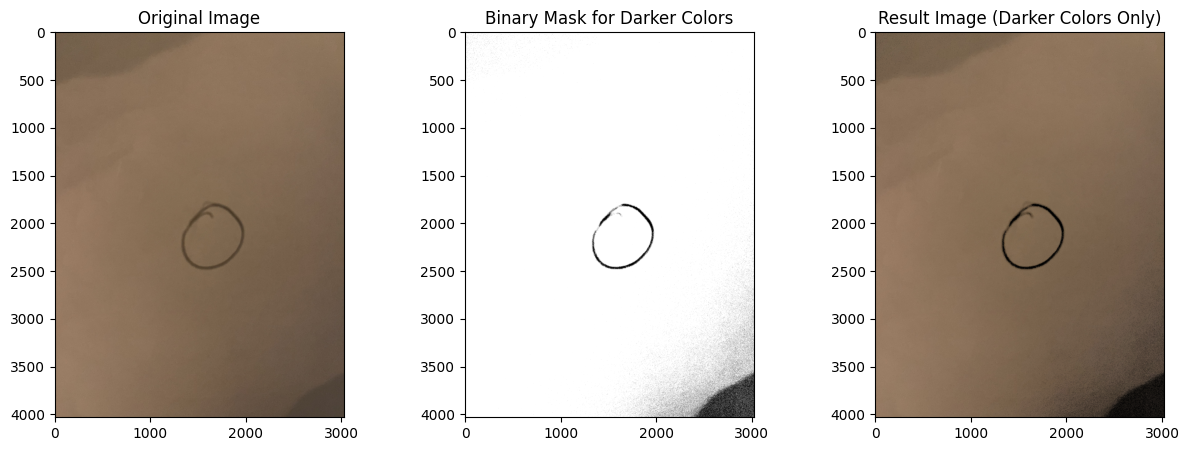

In [ ]:
# Load the image in color
image_path = 'IMG_0557.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set a threshold value for darker colors (adjust as needed)
threshold_value = 75

# Create a binary mask for pixels below the threshold
_, mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

# Apply the binary mask to the original image
result_image = cv2.bitwise_and(image, image, mask=mask)

# Display the original, mask, and result images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Binary Mask for Darker Colors')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image (Darker Colors Only)')